In [10]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms.functional import rotate
from torchvision.transforms import ToTensor, Lambda,Compose
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle

%matplotlib inline

# Dataset

In [11]:
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)


Files already downloaded and verified
Files already downloaded and verified


In [12]:
len(training_data),len(test_data)

(50000, 10000)

In [13]:
for X,y in training_data:
    print(X.shape, X.max(),X.min())
    break

torch.Size([3, 32, 32]) tensor(1.) tensor(-1.)


In [14]:
train_dataloaderF = DataLoader(training_data, batch_size=256,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64)

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Model

In [16]:
from torchvision.models import resnet18

In [17]:
loss_fn = nn.CrossEntropyLoss()

In [18]:
def compute_grad(model,X,y,device=device):
    model.train()
    g = [None for _ in model.parameters()]
    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for i,param in enumerate(model.parameters()):
            g[i] = param.grad
    return g, loss

## Random Core-sets

In [19]:
class dataset(Dataset):
    def __init__(self,C):
        self.X = C[0]
        self.y = C[1]
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]

In [20]:
DloadH = DataLoader(training_data, batch_size=2048,shuffle=True)

In [21]:
for coreset in DloadH:
    DlH = DataLoader(dataset(coreset), batch_size=64,shuffle=True)
    print(len(DlH))
    break

32


In [22]:
try:
    coreset = next(enumerate(DloadH))
except StopIteration:
    DloadH = iter(train_dataloaderH)
    coreset = next(DloadH)

In [23]:
def AUXMOM(lrs,a, model, loss_fn,epochs):
    Res = {"train_loss":[],"test_loss":[],"test_acc":[]}
    dloadH = iter(DloadH)
    for t in range(epochs):
              #print(f"Epoch {t+1}\n-------------------------------")
            size = len(train_dataloaderF.dataset)
            m_f = [None for _ in model.parameters()]
            for batch, (X, y) in enumerate(train_dataloaderF):
                lr = lrs[t*len(train_dataloaderF) + batch]
                
                g_f,_ = compute_grad(model,X,y,device=device)
                with torch.no_grad():
                    for i in range(len(m_f)):
                        m_f[i] = g_f[i] if batch==0 else (1-a)*m_f[i] + a*g_f[i]

                if batch % 3==0 :
                    try:
                        coreset = next(dloadH)
                    except StopIteration:
                        dloadH = iter(DloadH)
                        coreset = next(dloadH)
                    # Compute prediction and loss
                    DlH = DataLoader(dataset(coreset), batch_size=64,shuffle=True)
                backup = copy.deepcopy(model).to(device)
                for X,y in DlH:
                    grad_hx,_ = compute_grad(backup,X,y,device=device)
                    grad_hy, loss = compute_grad(model,X,y,device=device)
                    
                    with torch.no_grad():
                        for i,param in enumerate(model.parameters()):
                            param -= lr * (grad_hy[i] - grad_hx[i] + m_f[i])
                                   
                if batch % 50 == 0:
                    model.eval()
                    loss, current = loss.item(), batch * len(X)
                        # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                    Res["train_loss"].append(loss)
                        #test
                    size = len(test_dataloader.dataset)
                    num_batches = len(test_dataloader)
                    test_loss, correct = 0, 0

                    with torch.no_grad():
                        for X, y in test_dataloader:
                            X, y = X.to(device), y.to(device)
                            pred = model(X)
                            test_loss += loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                    test_loss /= num_batches
                    correct /= size
                    Res["test_loss"].append(test_loss)
                    Res["test_acc"].append(correct)
                    model.train()
                    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return Res

In [24]:
def Naive(lrs,a, model, loss_fn,epochs):
    Res = {"train_loss":[],"test_loss":[],"test_acc":[]}
    dloadH = iter(DloadH)
    for t in range(epochs):
              #print(f"Epoch {t+1}\n-------------------------------")
            size = len(train_dataloaderF.dataset)
            for batch, (X, y) in enumerate(train_dataloaderF):
                lr = lrs[t*len(train_dataloaderF) + batch]

                if batch % 3==0 :
                    try:
                        coreset = next(dloadH)
                    except StopIteration:
                        dloadH = iter(DloadH)
                        coreset = next(dloadH)
                    # Compute prediction and loss
                    DlH = DataLoader(dataset(coreset), batch_size=64,shuffle=True)
                for X,y in DlH:
                    grad_hy, loss = compute_grad(model,X,y,device=device)
                    
                    with torch.no_grad():
                        for i,param in enumerate(model.parameters()):
                            param -= lr * (grad_hy[i])
                                   
                if batch % 50 == 0:
                    model.eval()
                    loss, current = loss.item(), batch * len(X)
                        # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                    Res["train_loss"].append(loss)
                        #test
                    size = len(test_dataloader.dataset)
                    num_batches = len(test_dataloader)
                    test_loss, correct = 0, 0

                    with torch.no_grad():
                        for X, y in test_dataloader:
                            X, y = X.to(device), y.to(device)
                            pred = model(X)
                            test_loss += loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                    test_loss /= num_batches
                    correct /= size
                    Res["test_loss"].append(test_loss)
                    Res["test_acc"].append(correct)
                    model.train()
                    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return Res

In [83]:
trials = 2
epochs = 10
T = np.arange(len(train_dataloaderF)*epochs) + 1
lrs = 1e-2 * np.ones_like(T) #1e-1 / np.sqrt(T)
a = 0.1
Res = {"AUXMOM":{} , "Naive":{}}
for alg in Res:
    print(alg)
    for t in range(trials):
        print("---------t=",t)
        model = NeuralNetwork().to(device)
        if alg == "AUXMOM":
            Res[alg] = AUXMOM(lrs,a, model, loss_fn,epochs)
        else:
            Res[alg] = Naive(lrs,a, model, loss_fn,epochs)
        with open(f'results/MnistExp_Coreset2.pkl', 'wb') as f:
            pickle.dump(Res, f)

Naive
---------t= 0
---------t= 1


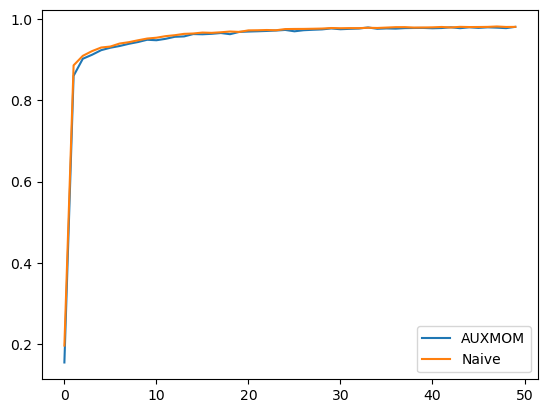

In [89]:
for alg in Res:
    plt.plot(Res[alg]["test_acc"],label = alg)
plt.legend()

### Second exp:

In [25]:
DloadH = DataLoader(training_data, batch_size=len(training_data)//10,shuffle=True)

In [26]:
from tqdm import tqdm

In [27]:
def AUXMOM(lrs,a, model, loss_fn,epochs):
    Res = {"train_loss":[],"test_loss":[],"test_acc":[]}
    dloadH = iter(DloadH)
    coreset = next(dloadH)
    DlH = DataLoader(dataset(coreset), batch_size=64,shuffle=True)
    m_f = [None for _ in model.parameters()]
    for t in tqdm(range(epochs)):
              #print(f"Epoch {t+1}\n-------------------------------")
            size = len(train_dataloaderF.dataset)
            for batch, (X, y) in enumerate(train_dataloaderF):
                lr = lrs[t*len(train_dataloaderF) + batch]
                
                g_f,_ = compute_grad(model,X,y,device=device)
                with torch.no_grad():
                    for i in range(len(m_f)):
                        m_f[i] = g_f[i] if (batch==0 and t==0) else (1-a)*m_f[i] + a*g_f[i]
  
                backup = copy.deepcopy(model).to(device)
                for X,y in DlH:
                    grad_hx,_ = compute_grad(backup,X,y,device=device)
                    grad_hy, loss = compute_grad(model,X,y,device=device)
                    
                    with torch.no_grad():
                        for i,param in enumerate(model.parameters()):
                            param -= lr * (grad_hy[i] - grad_hx[i] + m_f[i])
                                   
                if batch % 50 == 0:
                    model.eval()
                    loss, current = loss.item(), batch * len(X)
                        # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                    Res["train_loss"].append(loss)
                        #test
                    size = len(test_dataloader.dataset)
                    num_batches = len(test_dataloader)
                    test_loss, correct = 0, 0

                    with torch.no_grad():
                        for X, y in test_dataloader:
                            X, y = X.to(device), y.to(device)
                            pred = model(X)
                            test_loss += loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                    test_loss /= num_batches
                    correct /= size
                    Res["test_loss"].append(test_loss)
                    Res["test_acc"].append(correct)
                    model.train()
                    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return Res

In [28]:
def Naive(lrs,a, model, loss_fn,epochs):
    Res = {"train_loss":[],"test_loss":[],"test_acc":[]}
    dloadH = iter(DloadH)
    coreset = next(dloadH)
    DlH = DataLoader(dataset(coreset), batch_size=64,shuffle=True)
    for t in tqdm(range(epochs)):
              #print(f"Epoch {t+1}\n-------------------------------")
            size = len(train_dataloaderF.dataset)
            for batch, (X, y) in enumerate(train_dataloaderF):
                lr = lrs[t*len(train_dataloaderF) + batch]

                for X,y in DlH:
                    grad_hy, loss = compute_grad(model,X,y,device=device)
                    
                    with torch.no_grad():
                        for i,param in enumerate(model.parameters()):
                            param -= lr * (grad_hy[i])
                                   
                if batch % 50 == 0:
                    model.eval()
                    loss, current = loss.item(), batch * len(X)
                        # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                    Res["train_loss"].append(loss)
                        #test
                    size = len(test_dataloader.dataset)
                    num_batches = len(test_dataloader)
                    test_loss, correct = 0, 0

                    with torch.no_grad():
                        for X, y in test_dataloader:
                            X, y = X.to(device), y.to(device)
                            pred = model(X)
                            test_loss += loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                    test_loss /= num_batches
                    correct /= size
                    Res["test_loss"].append(test_loss)
                    Res["test_acc"].append(correct)
                    model.train()
                    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return Res

In [22]:
trials = 1
epochs = 4
T = np.arange(len(train_dataloaderF)*epochs) + 1
lrs = 1e-3 * np.ones_like(T) #1e-1 / np.sqrt(T)
a = 0.1
Res = {"AUXMOM":{} , "Naive":{}}
for alg in Res:
    print(alg)
    for t in range(trials):
        print("---------t=",t)
        model = resnet18().to(device)
        if alg == "AUXMOM":
            Res[alg][t] = AUXMOM(lrs,a, model, loss_fn,epochs)
        else:
            Res[alg][t] = Naive(lrs,a, model, loss_fn,epochs)
        with open(f'results/CIFAR10_ResNet18Exp_Coreset.pkl', 'wb') as f:
            pickle.dump(Res, f)

AUXMOM
---------t= 0


100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:07:33<00:00, 1013.41s/it]


Naive
---------t= 0


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [33:10<00:00, 497.68s/it]


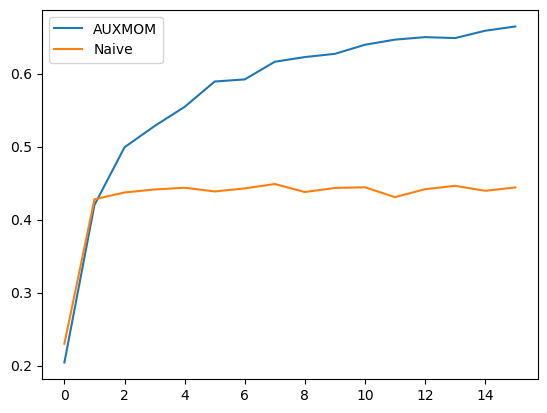

In [23]:
for alg in Res:
    plt.plot(Res[alg][0]["test_acc"],label = alg)
plt.legend()

In [32]:
D3 = Res

In [79]:
with open(f'results/CIFAR10Exp_Coreset4.pkl', 'rb') as f:
            D3 = pickle.load(f)

AUXMOM 0.6453
Naive 0.511175


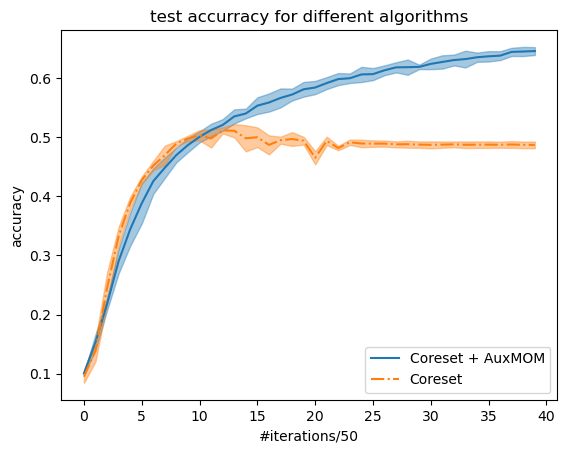

In [80]:
tp = "test_acc"
trials = 4
labels = ["Coreset + AuxMOM","Coreset"]
linestyles = ["solid",'dashdot']
algs = ["AUXMOM","Naive"]
x = 0
for idx,(ls,alg) in enumerate(zip(linestyles,algs)):
    arr = np.zeros((trials,len(D3[alg][0][tp][x:])))
    for i in range(trials):
        arr[i] = D3[alg][i][tp][x:]
    yfit = arr.mean(0)
    dyfit = arr.std(0)
    print(alg,yfit.max())
    p = plt.plot(np.arange(len(yfit)),yfit,linestyle=ls,label=labels[idx])
    color=p[0].get_color()
    plt.fill_between(np.arange(len(yfit)),yfit - dyfit, yfit + dyfit,color=color,alpha=0.4)

plt.title("test accurracy for different algorithms")
plt.xlabel("#iterations/50")
plt.ylabel("accuracy")
plt.legend(loc=4)
plt.savefig("coresetexpCIFAR10.pdf")

In [97]:
train_dataloaderF = DataLoader(training_data, batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64)

In [68]:
dloadH = iter(DloadH)
coreset = next(dloadH)
DlH = DataLoader(dataset(coreset), batch_size=64,shuffle=True)
len(DlH)

157

In [73]:
2455 * 40/len(train_dataloaderF)

125.57544757033249

In [98]:
def Normal(lrs,a, model, loss_fn,epochs):
    Res = {"train_loss":[],"test_loss":[],"test_acc":[]}
    iterations = 0
    m_f = [None for _ in model.parameters()]
    for t in tqdm(range(epochs)):
              #print(f"Epoch {t+1}\n-------------------------------")
            size = len(train_dataloaderF.dataset)
            for batch, (X, y) in enumerate(train_dataloaderF):
                lr = lrs[t*len(train_dataloaderF) + batch]
                
                g_f,loss = compute_grad(model,X,y,device=device)
                with torch.no_grad():
                    for i in range(len(m_f)):
                        m_f[i] = g_f[i] if (batch==0 and t==0) else (1-a)*m_f[i] + a*g_f[i]
  
                    
                with torch.no_grad():
                    for i,param in enumerate(model.parameters()):
                        param -= lr * m_f[i]
                                   
                if iterations % 2455 == 0:
                    loss, current = loss.item(), batch * len(X)
                        # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                    Res["train_loss"].append(loss)
                        #test
                    size = len(test_dataloader.dataset)
                    num_batches = len(test_dataloader)
                    test_loss, correct = 0, 0

                    with torch.no_grad():
                        for X, y in test_dataloader:
                            X, y = X.to(device), y.to(device)
                            pred = model(X)
                            test_loss += loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                    test_loss /= num_batches
                    correct /= size
                    Res["test_loss"].append(test_loss)
                    Res["test_acc"].append(correct)
                iterations += 1
                    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return Res

In [99]:
trials = 4
epochs = 126
T = np.arange(len(train_dataloaderF)*epochs) + 1
lrs = 1e-2 * np.ones_like(T) #1e-1 / np.sqrt(T)
a = 0.1
Res = {"Normal":{}}
alg = "Normal"
for t in range(trials):
    print("---------t=",t)
    model = NeuralNetwork().to(device)
    Res[alg][t] = Normal(lrs,a, model, loss_fn,epochs)
    with open(f'results/CIFAR10Exp_Coreset3_normal1,1.pkl', 'wb') as f:
            pickle.dump(Res, f)

---------t= 0


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [25:16<00:00, 12.04s/it]


---------t= 1


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [24:36<00:00, 11.72s/it]


---------t= 2


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [23:42<00:00, 11.29s/it]


---------t= 3


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [23:40<00:00, 11.27s/it]


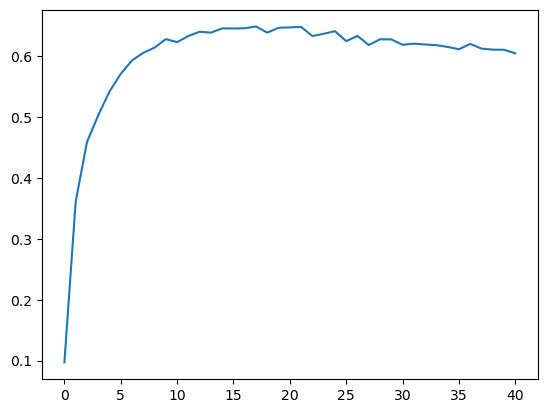

In [100]:
plt.plot(Res[alg][0]["test_acc"])

In [101]:
with open(f'results/CIFAR10Exp_CoresetEXPP.pkl', 'rb') as f:
            D3 = pickle.load(f)
D3[alg] = Res[alg]

In [102]:
for alg in D3:
    print(alg)

AUXMOM
Naive
Normal
Normal2


In [92]:
with open(f'results/CIFAR10Exp_CoresetEXPP.pkl', 'wb') as f:
            pickle.dump(D3,f)

In [43]:
with open(f'results/CIFAR10Exp_Coreset3.pkl', 'rb') as f:
            D3 = pickle.load(f)

In [ ]:
plt.figure(figsize=(3,3))
linestyles = ["solid",'dashdot','dotted','dashed']
for k,ls in zip(Res,linestyles):
  arr = dic[tp][k]
  yfit = arr.mean(0)
  dyfit = arr.std(0)
  print(k,yfit.max())
  p = plt.plot(yfit,linestyle=ls,label="K="+str(k))
  color=p[0].get_color()
  plt.fill_between(np.arange(len(yfit)),yfit - dyfit, yfit + dyfit,color=color,alpha=0.4)

In [4]:
with open(f'results/CIFAR10Exp_CoresetEXPP.pkl', 'rb') as f:
            D3 = pickle.load(f)

In [7]:
with open(f'results/CIFAR10Exp_Coreset3_normal1,1.pkl', 'rb') as f:
            Res = pickle.load(f)
D3["Normal"] = Res["Normal"]

AUXMOM 0.6453
Naive 0.511175
Normal 0.648375
Normal2 0.3144


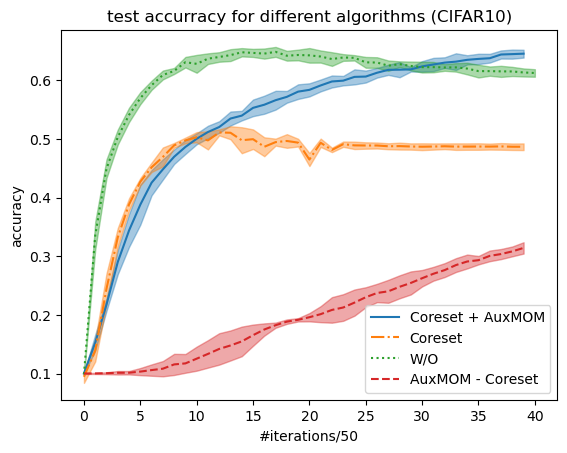

In [8]:
tp = "test_acc"
trials = 4
labels = ["Coreset + AuxMOM","Coreset","W/O","AuxMOM - Coreset"]
linestyles = ["solid",'dashdot','dotted','dashed']
algs = ["AUXMOM","Naive","Normal","Normal2"]
x = 0
for idx,(ls,alg) in enumerate(zip(linestyles,algs)):
    arr = np.zeros((trials,len(D3[alg][0][tp][x:])))
    for i in range(trials):
        arr[i] = D3[alg][i][tp]
    yfit = arr.mean(0)
    dyfit = arr.std(0)
    print(alg,yfit.max())
    p = plt.plot(np.arange(len(yfit)),yfit,linestyle=ls,label=labels[idx])
    color=p[0].get_color()
    plt.fill_between(np.arange(len(yfit)),yfit - dyfit, yfit + dyfit,color=color,alpha=0.4)

plt.title("test accurracy for different algorithms (CIFAR10)")
plt.xlabel("#iterations/50")
plt.ylabel("accuracy")
plt.legend(loc=4)
plt.savefig("CIFAR10coresetexp2.pdf")

In [66]:
np.arange(30,50)

array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49])

In [24]:
with open(f'results/MnistExp_Coreset2.pkl', 'rb') as f:
            D3 = pickle.load(f)

In [25]:
for alg in D3: print(alg)

AUXMOM
Naive


AUXMOM 0.9814499999999999
Naive 0.96255


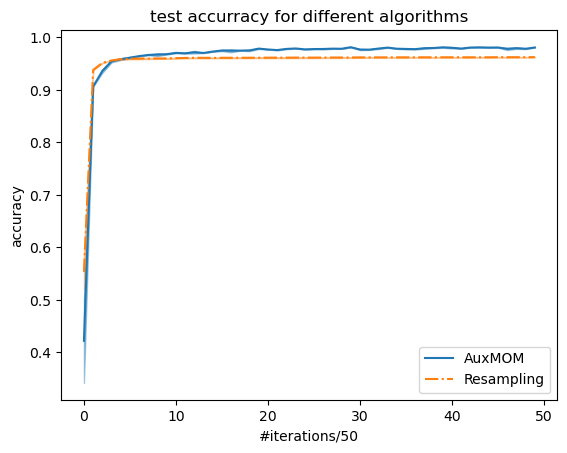

In [26]:
tp = "test_acc"
trials = 2
labels = ["AuxMOM","Resampling"]
linestyles = ["solid",'dashdot']
algs = ["AUXMOM","Naive"]
x = 0
for idx,(ls,alg) in enumerate(zip(linestyles,algs)):
    arr = np.zeros((trials,len(D3[alg][0][tp][x:])))
    for i in range(trials):
        arr[i] = D3[alg][i][tp][x:]
    yfit = arr.mean(0)
    dyfit = arr.std(0)
    print(alg,yfit.max())
    p = plt.plot(np.arange(x,50),yfit,linestyle=ls,label=labels[idx])
    color=p[0].get_color()
    plt.fill_between(np.arange(x,50),yfit - dyfit, yfit + dyfit,color=color,alpha=0.4)

plt.title("test accurracy for different algorithms")
plt.xlabel("#iterations/50")
plt.ylabel("accuracy")
plt.legend(loc=4)
plt.savefig("coresetexpResampling.pdf")